### IMPORTING NECESSARY LIBRAIRES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random
import copy
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

#### SIMULATING BIOMARKER DATA

In [4]:
def sigmoid_function(a,b,x):
    return 1/(1+np.exp(a*(b-x)))

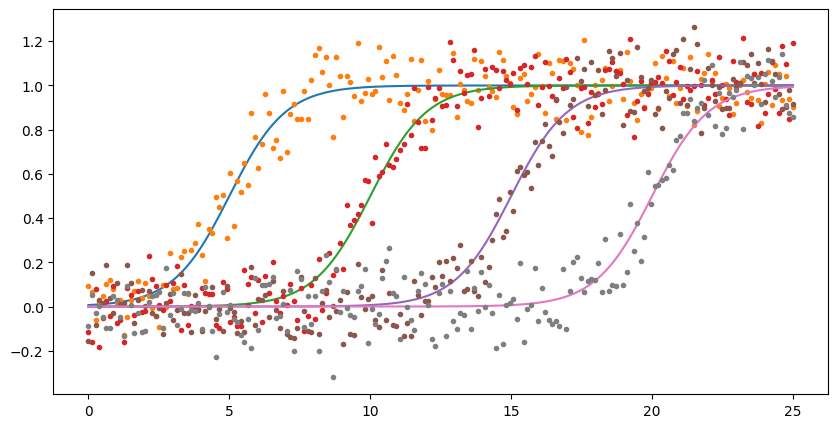

In [5]:
number_of_patients = 200
number_of_biomarkers = 4
onset_times = [5,10,15,20]
time_points = np.linspace(0,25,number_of_patients)

patient_data = np.empty(shape=(number_of_patients,number_of_biomarkers))
noise_value = 0.1
fig,ax = plt.subplots(figsize=(10,5))

for onset_time,biomarker_number in zip(onset_times,range(number_of_biomarkers)):
    biomarker_values = sigmoid_function(1,onset_time,time_points)
    ax.plot(time_points, biomarker_values)
    
    noise = np.random.normal(0,noise_value,len(time_points))
    biomarker_values+=noise
    ax.plot(time_points, biomarker_values,'.')
    
    patient_data[:,biomarker_number] = biomarker_values

#### SIMULATING CONTROL DATA

In [6]:
control_data = np.empty(shape=(number_of_patients,number_of_biomarkers))
for biomarker_number in range(number_of_biomarkers):
    control_data[:,biomarker_number] = np.random.normal(0,0.05,number_of_patients)

#### DATA PRE-PROCESSING

In [7]:
Y_patients = np.ones(shape=(number_of_patients,1))
Y_controls = np.zeros(shape=(number_of_patients,1))

X = np.concatenate((patient_data,control_data),axis=0)
Y = np.concatenate((Y_patients,Y_controls),axis=0).flatten().astype(int)

In [8]:
biomarker_name = ['BM1','BM2','BM3','BM4']
condition_name = ['CN','AD']

X_ = pd.DataFrame(X,columns=biomarker_name)
Y_ = pd.DataFrame(Y,columns=['Condition'])

Y_Name = Y_.apply(lambda x : condition_name[x[0]],axis=1)
Y_Name = pd.DataFrame(Y_Name,columns=['Condition Name'])

In [9]:
df = pd.concat((X_,Y_Name,Y_),axis=1)
df.head()

,BM1,BM2,BM3,BM4,Condition Name,Condition
0,0.091064,-0.116405,-0.153811,-0.085911,AD,1
1,0.067346,-0.161281,0.153085,0.051517,AD,1
2,-0.062881,0.077495,-0.082401,-0.030979,AD,1
3,0.020219,-0.184478,0.027618,0.004264,AD,1
4,0.045995,-0.053082,0.014078,-0.046849,AD,1


#### HISTOGRAM OF BIOMARKER VALUES IN PATIENT VS CONTROL SUBPOPULATION

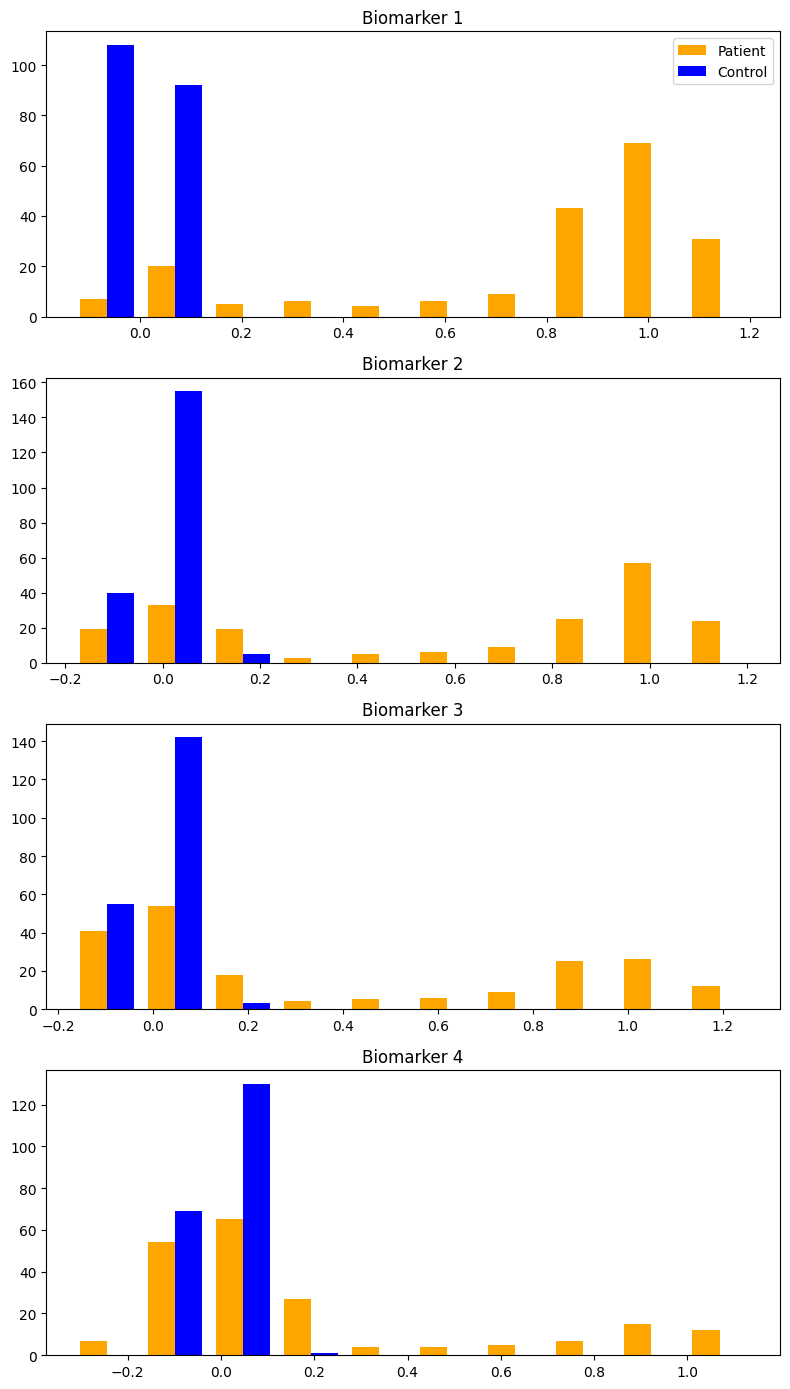

In [10]:
fig,ax = plt.subplots(4,1,figsize=(8,14))
for biomarker_number in range(number_of_biomarkers):
    ax[biomarker_number].hist([patient_data[:,biomarker_number],control_data[:,biomarker_number]],label=['Patient','Control'],color=['orange','blue'])
    ax[biomarker_number].set_title('Biomarker '+ str(biomarker_number+1))
ax[0].legend()
fig.tight_layout()

#### FITTING MIXTURE MODELS

In [11]:
def EM(X,number_of_clusters=2,number_of_iterations = 300):

    iteration_nums = []
    likelihood = []
    
    means = np.linspace(min(X),max(X),number_of_clusters)
    stds = np.ones(number_of_clusters)
    weights = np.full(number_of_clusters,1.0/number_of_clusters)

    for iteration in range(1,number_of_iterations):
        contribution = []
        
        for i in range(number_of_clusters):
            contribution.append(weights[i]*norm.pdf(X,means[i],stds[i]))
    
        contribution = np.array(contribution)/np.sum(contribution,axis=0)
        
        for i in range(number_of_clusters):
            weights[i] = np.mean(contribution[i])
            means[i] = np.sum(contribution[i]*X)/np.sum(contribution[i])
            stds[i] = np.sqrt(np.sum(contribution[i]*(X - means[i])**2)/np.sum(contribution[i]))

        log_likelihood = np.sum(np.log(np.sum([weights[i]*norm.pdf(X,means[i],stds[i]) for i in range(2)],axis=0)))
        
        if iteration>10 and np.array_equal(np.full(10,np.round(log_likelihood,2)),np.round(likelihood[-10:],2)):
            break
        else:
            likelihood.append(log_likelihood)
            iteration_nums.append(iteration)

    return means,stds,weights

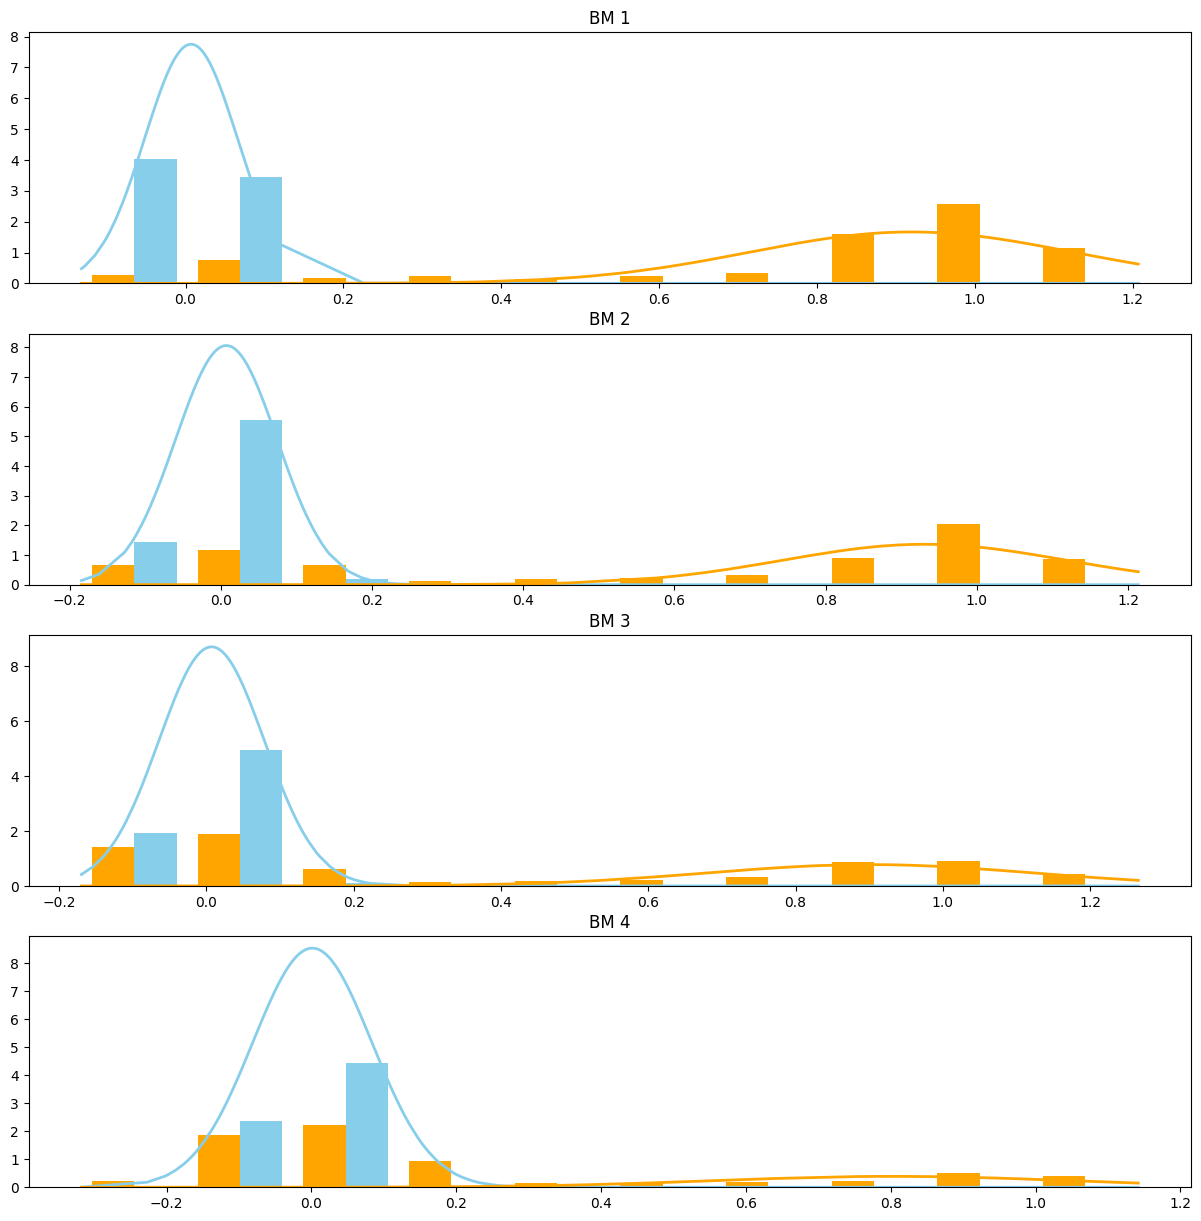

In [12]:
number_of_biomarkers = len(biomarker_name)
fig,ax = plt.subplots(4,1,figsize=(15,15))
gmm_parameters = {}

for biomarker_number in range(number_of_biomarkers):
    
    biomarker_data = df.iloc[:,biomarker_number]
    means,stds,weights = EM(biomarker_data)

    # Original Data with Labels
    ad_data = df[df['Condition Name']=='AD'].iloc[:,biomarker_number]
    cn_data = df[df['Condition Name']=='CN'].iloc[:,biomarker_number]

    ax[biomarker_number].hist([ad_data,cn_data],label=['AD','CN'],color=['orange','skyblue'],density=True,bins=10)
    gmm_parameters['BM'+ str(biomarker_number+1)] = [weights,means,stds]

    # Fitted GMM model
    X_sorted = np.sort(biomarker_data)
    cn_density_estimation = weights[0]*norm.pdf(X_sorted, means[0],stds[0])
    ad_density_estimation = weights[1]*norm.pdf(X_sorted, means[1],stds[1])
    density_estimation = (cn_density_estimation + ad_density_estimation)
    ax[biomarker_number].plot(X_sorted,cn_density_estimation*2, color='skyblue', linewidth=2)
    ax[biomarker_number].plot(X_sorted,ad_density_estimation*2, color='orange', linewidth=2)
    ax[biomarker_number].set_title('BM '+ str(biomarker_number+1))

#### DEFINING NECESSARY FUNCTIONS

In [97]:
def patient_likelihood_at_K(individual_data,event_sequence,K,gmm_parameters):

    ''' If a patient is at the position k in the progression model,
        where events upto k have occured and rest have not'''
    
    event_position = list(event_sequence).index(K)
    events_occured = event_sequence[:event_position+1]
    events_not_occured = event_sequence[event_position+1:]
    likelihood = 1
    
    for event in events_occured:
        biomarker_value = individual_data[event]
        high_mean = gmm_parameters[event][1][1]
        high_std = gmm_parameters[event][2][1]
        likelihood*=norm.pdf(biomarker_value,high_mean,high_std)
        
    for events in events_not_occured:
        biomarker_value = individual_data[event]
        low_mean = gmm_parameters[event][1][0]
        low_std = gmm_parameters[event][2][0]
        likelihood*=norm.pdf(biomarker_value,low_mean,low_std)

    return likelihood

def patient_likelihood(individual_data,event_sequence,gmm_parameters):

    ''' Integrating out the hidden variable K '''
    
    uniform_prior = 1.0/len(event_sequence)
    for event in event_sequence:
        likelihood_at_k = patient_likelihood_at_K(individual_data,event_sequence,event,gmm_parameters)
        individual_data_likelihood=uniform_prior*likelihood_at_k

    print(individual_data_likelihood)
    return np.log(individual_data_likelihood)

def data_likelihood(patients_data,event_sequence,gmm_parameters):
    data_likelihood = 0
    for patient_number in range(len(patients_data)):
        individual_data = X[patient_number]
        processed_data = {}
        for biomarker_number in range(len(individual_data)):
            processed_data['BM'+ str(biomarker_number+1)] = individual_data[biomarker_number].item()
        
        data_likelihood+=patient_likelihood(processed_data,event_sequence,gmm_parameters)
        
    return data_likelihood

In [99]:
X = patient_data[-20:]
current_sequence = copy.deepcopy(biomarker_name[::-1])
data_likelihood(X,current_sequence,gmm_parameters)

1.249569126189414
0.6159014731178348
1.281050780995929
1.397085624175702
1.3883168880986254
2.3997606262274527
0.7269827591771494
0.779696155783979
1.0191954587588599
1.9368935307708264
0.7630268509267786
1.0658774041598515
1.8093771678334332
2.4859871941873455
0.6698704900221863
0.4711306337262996
1.541819163921283
1.0548293726831606
1.5247024072947863
0.2238911577640596


1.191300199839581

#### GREEDY ASCENT ALGORITHM

In [84]:
X = patient_data

sequences = []
iterations = 50

current_sequence = copy.deepcopy(biomarker_name[::-1])
current_likelihood = data_likelihood(X,current_sequence,gmm_parameters)

for iteration_number in tqdm(range(iterations)):
    new_sequence = copy.deepcopy(current_sequence)
    index_1, index_2 = random.sample(range(len(new_sequence)), 2)
    new_sequence[index_1], new_sequence[index_2] = new_sequence[index_2], new_sequence[index_1]
    print(current_likelihood,new_likelihood)
    new_likelihood = data_likelihood(X,new_sequence,gmm_parameters)
    if new_likelihood>current_likelihood:
        current_likelihood=new_likelihood
        current_sequence=new_sequence
    sequences.append(current_sequence)

print(sequences)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

nan nan


  2%|█▋                                                                                 | 1/50 [00:00<00:36,  1.36it/s]

nan nan


  4%|███▎                                                                               | 2/50 [00:01<00:35,  1.36it/s]

nan nan


  6%|████▉                                                                              | 3/50 [00:02<00:34,  1.36it/s]

nan nan


  8%|██████▋                                                                            | 4/50 [00:03<00:35,  1.30it/s]


nan nan


KeyboardInterrupt: 